In [6]:
import wgpu
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import math
import time
from tqdm import tqdm
from ctypes import Structure, c_int, c_char, c_byte, c_float, c_int, c_uint, sizeof

In [2]:
adapter_0 = wgpu.gpu.request_adapter_sync(power_preference="high-performance")
device_0 = adapter_0.request_device_sync(
    required_features=[wgpu.FeatureName.timestamp_query]
)
pprint(adapter_0.info)

adapter_1 = wgpu.gpu.request_adapter_sync(power_preference="low-power")
device_1 = adapter_1.request_device_sync(
    required_features=[wgpu.FeatureName.timestamp_query]
)
pprint(adapter_1.info)

if 0:
    adapter = adapter_0
    device = device_0
else:
    adapter = adapter_1
    device = device_1

pprint(adapter.info)

{'adapter_type': 'IntegratedGPU',
 'architecture': '',
 'backend_type': 'Vulkan',
 'description': '24.12.1 (AMD proprietary shader compiler)',
 'device': 'AMD Radeon(TM) Graphics',
 'device_id': 5761,
 'vendor': 'AMD proprietary driver',
 'vendor_id': 4098}
{'adapter_type': 'IntegratedGPU',
 'architecture': '',
 'backend_type': 'Vulkan',
 'description': '24.12.1 (AMD proprietary shader compiler)',
 'device': 'AMD Radeon(TM) Graphics',
 'device_id': 5761,
 'vendor': 'AMD proprietary driver',
 'vendor_id': 4098}
{'adapter_type': 'IntegratedGPU',
 'architecture': '',
 'backend_type': 'Vulkan',
 'description': '24.12.1 (AMD proprietary shader compiler)',
 'device': 'AMD Radeon(TM) Graphics',
 'device_id': 5761,
 'vendor': 'AMD proprietary driver',
 'vendor_id': 4098}


In [301]:
def prod(*args, start=1):
    v = start
    for arg in args:
        v *= arg
    return v

class KernelCurrentSource:
    class Params(Structure):
        _fields_ = [
            ("Nx", c_uint),
            ("Ny", c_uint),
            ("Nz", c_uint),
            ("x0", c_uint),
            ("y0", c_uint),
            ("z0", c_uint),
            ("E0", c_float),
        ]
    
    def __init__(self, workgroup_size, device, label=None):
        self.label = label or "current_source"
        self.device = device
        self.workgroup_size = workgroup_size
        
        self.params = self.__class__.Params()
        self.params_uniform = device.create_buffer(
            label="grid_size", 
            size=sizeof(self.params), 
            usage=wgpu.BufferUsage.UNIFORM | wgpu.BufferUsage.COPY_DST,
        )
        self.n_dims = 3
        
        self.shader_source = f"""
            struct Params {{
                size_x: u32,
                size_y: u32,
                size_z: u32,
                x0: u32,
                y0: u32,
                z0: u32,
                E0: f32,
            }}
        
            @group(0) @binding(0) var<uniform> params: Params;
            @group(0) @binding(1) var<storage,read_write> E: array<f32>;
            
            @compute
            @workgroup_size({",".join(map(str, self.workgroup_size))})
            fn main(@builtin(global_invocation_id) _i: vec3<u32>) {{
                let Nx = params.size_x;
                let Ny = params.size_y;
                let Nz = params.size_z;
                let n_dims: u32 = u32({self.n_dims});
                let Nzy = Nz*Ny;
                
                let ix = _i.x + params.x0;
                let iy = _i.y + params.y0;
                let iz = _i.z + params.z0;
                if (ix >= Nx) {{ return; }}
                if (iy >= Ny) {{ return; }}
                if (iz >= Nz) {{ return; }}

                let i0 = iz + iy*Nz + ix*Nzy;
                let i = n_dims*i0;

                let e0 = params.E0;
                E[i+0] += e0;
            }}
        """
        self.shader_module = self.device.create_shader_module(code=self.shader_source)
        self.binding_layouts = [
            {
                "binding": i,
                "visibility": wgpu.ShaderStage.COMPUTE,
                "buffer": { "type": bind_type },
            }
            for i, bind_type in enumerate([
                wgpu.BufferBindingType.uniform,
                wgpu.BufferBindingType.storage,
            ])
        ]
        self.bind_group_layout = self.device.create_bind_group_layout(entries=self.binding_layouts)
        self.pipeline_layout = self.device.create_pipeline_layout(bind_group_layouts=[self.bind_group_layout])
        self.compute_pipeline = device.create_compute_pipeline(
            layout=self.pipeline_layout,
            compute={"module": self.shader_module, "entry_point": "main"},
        )

    def create_pass(self, command_encoder, E, e0, grid_size, offset, region, timestamp_writes=None):
        dispatch_size = [math.ceil(g/l) for g,l in zip(region, self.workgroup_size)]

        self.params.Nx = grid_size[0]
        self.params.Ny = grid_size[1]
        self.params.Nz = grid_size[2]
        self.params.x0 = offset[0]
        self.params.y0 = offset[1]
        self.params.z0 = offset[2]
        self.params.E0 = e0
        device.queue.write_buffer(self.params_uniform, 0, (c_byte*sizeof(self.params)).from_buffer(self.params), 0, sizeof(self.params))
        
        compute_pass = command_encoder.begin_compute_pass(label=self.label, timestamp_writes=timestamp_writes)
        compute_pass.set_pipeline(self.compute_pipeline)
        bindings = [
            {
                "binding": 0,
                "resource": {"buffer": self.params_uniform, "offset": 0, "size": self.params_uniform.size},
            },
            {
                "binding": 1,
                "resource": {"buffer": E, "offset": 0, "size": E.size},
            },
        ]
        bind_group = self.device.create_bind_group(layout=self.bind_group_layout, entries=bindings)
        compute_pass.set_bind_group(0, bind_group)
        compute_pass.dispatch_workgroups(*dispatch_size)
        compute_pass.end()
        return compute_pass

class KernelUpdateE:
    class Params(Structure):
        _fields_ = [
            ("x", c_uint),
            ("y", c_uint),
            ("z", c_uint),
            ("_pad1", c_byte*4),
        ]
    
    def __init__(self, workgroup_size, device, label=None):
        self.label = label or "update_e_field"
        self.device = device
        self.workgroup_size = workgroup_size
        
        self.params = self.__class__.Params()
        self.params_uniform = device.create_buffer(
            label="grid_size", 
            size=sizeof(self.params), 
            usage=wgpu.BufferUsage.UNIFORM | wgpu.BufferUsage.COPY_DST,
        )
        self.n_dims = 3
        
        self.shader_source = f"""
            struct Params {{
                size_x: u32,
                size_y: u32,
                size_z: u32,
            }}
        
            @group(0) @binding(0) var<uniform> params: Params;
            @group(0) @binding(1) var<storage,read_write> E: array<f32>;
            @group(0) @binding(2) var<storage,read> H: array<f32>;
            @group(0) @binding(3) var<storage,read> A0: array<f32>;
            @group(0) @binding(4) var<storage,read> A1: array<f32>;
            // a0 = 1/(1+sigma_k/e_k*dt)
            // a1 = 1/(e_k*d_xyz) * dt
            
            @compute
            @workgroup_size({",".join(map(str, self.workgroup_size))})
            fn main(@builtin(global_invocation_id) _i: vec3<u32>) {{
                let Nx = params.size_x;
                let Ny = params.size_y;
                let Nz = params.size_z;
                let n_dims: u32 = u32({self.n_dims});
                let Nzy = Nz*Ny;
                
                let ix = _i.x;
                let iy = _i.y;
                let iz = _i.z;
                if (ix >= Nx) {{ return; }}
                if (iy >= Ny) {{ return; }}
                if (iz >= Nz) {{ return; }}

                let i0 = iz + iy*Nz + ix*Nzy;
                let i = n_dims*i0;
                let dz = n_dims*(((iz+1) % Nz) + iy*Nz + ix*Nzy);
                let dy = n_dims*(iz + ((iy+1) % Ny)*Nz + ix*Nzy);
                let dx = n_dims*(iz + iy*Nz + ((ix+1) % Nx)*Nzy);

                let dHz_dy = H[dy+2]-H[i+2];
                let dHy_dz = H[dz+1]-H[i+1];
                let dHx_dz = H[dz+0]-H[i+0];
                let dHz_dx = H[dx+2]-H[i+2];
                let dHy_dx = H[dx+1]-H[i+1]; 
                let dHx_dy = H[dy+0]-H[i+0];
                let cHx = dHz_dy-dHy_dz;
                let cHy = dHx_dz-dHz_dx;
                let cHz = dHy_dx-dHx_dy;
            
                let a0 = A0[i0];
                let a1 = A1[i0];
            
                E[i+0] = a0*(E[i+0] + a1*cHx);
                E[i+1] = a0*(E[i+1] + a1*cHy);
                E[i+2] = a0*(E[i+2] + a1*cHz);

            }}
        """
        self.shader_module = self.device.create_shader_module(code=self.shader_source)
        self.binding_layouts = [
            {
                "binding": i,
                "visibility": wgpu.ShaderStage.COMPUTE,
                "buffer": { "type": bind_type },
            }
            for i, bind_type in enumerate([
                wgpu.BufferBindingType.uniform,
                wgpu.BufferBindingType.storage,
                wgpu.BufferBindingType.read_only_storage,
                wgpu.BufferBindingType.read_only_storage,
                wgpu.BufferBindingType.read_only_storage,
            ])
        ]
        self.bind_group_layout = self.device.create_bind_group_layout(entries=self.binding_layouts)
        self.pipeline_layout = self.device.create_pipeline_layout(bind_group_layouts=[self.bind_group_layout])
        self.compute_pipeline = device.create_compute_pipeline(
            layout=self.pipeline_layout,
            compute={"module": self.shader_module, "entry_point": "main"},
        )

    def create_pass(self, command_encoder, E, H, A0, A1, grid_size, timestamp_writes=None):
        dispatch_size = [math.ceil(g/l) for g,l in zip(grid_size, self.workgroup_size)]

        self.params.x = grid_size[0]
        self.params.y = grid_size[1]
        self.params.z = grid_size[2]
        device.queue.write_buffer(self.params_uniform, 0, (c_byte*sizeof(self.params)).from_buffer(self.params), 0, sizeof(self.params))
        
        compute_pass = command_encoder.begin_compute_pass(label=self.label, timestamp_writes=timestamp_writes)
        compute_pass.set_pipeline(self.compute_pipeline)
        bindings = [
            {
                "binding": 0,
                "resource": {"buffer": self.params_uniform, "offset": 0, "size": self.params_uniform.size},
            },
            {
                "binding": 1,
                "resource": {"buffer": E, "offset": 0, "size": E.size},
            },
            {
                "binding": 2,
                "resource": {"buffer": H, "offset": 0, "size": H.size},
            },
            {
                "binding": 3,
                "resource": {"buffer": A0, "offset": 0, "size": A0.size},
            },
            {
                "binding": 4,
                "resource": {"buffer": A1, "offset": 0, "size": A1.size},
            },
        ]
        bind_group = self.device.create_bind_group(layout=self.bind_group_layout, entries=bindings)
        compute_pass.set_bind_group(0, bind_group)
        compute_pass.dispatch_workgroups(*dispatch_size)
        compute_pass.end()
        return compute_pass

class KernelUpdateH:
    class Params(Structure):
        _fields_ = [
            ("x", c_uint),
            ("y", c_uint),
            ("z", c_uint),
            ("b0", c_float),
        ]
    
    def __init__(self, workgroup_size, device, label=None):
        self.label = label or "update_h_field"
        self.device = device
        self.workgroup_size = workgroup_size
        
        self.params = self.__class__.Params()
        self.params_uniform = device.create_buffer(
            label="grid_size", 
            size=sizeof(self.params), 
            usage=wgpu.BufferUsage.UNIFORM | wgpu.BufferUsage.COPY_DST,
        )
        self.n_dims = 3
        
        self.shader_source = f"""
            struct Params {{
                size_x: u32,
                size_y: u32,
                size_z: u32,
                // b0 = 1/(mu_k*d_xyz) * dt
                b0: f32,
            }}
        
            @group(0) @binding(0) var<uniform> params: Params;
            @group(0) @binding(1) var<storage,read> E: array<f32>;
            @group(0) @binding(2) var<storage,read_write> H: array<f32>;

            @compute
            @workgroup_size({",".join(map(str, self.workgroup_size))})
            fn main(@builtin(global_invocation_id) _i: vec3<u32>) {{
                let Nx = params.size_x;
                let Ny = params.size_y;
                let Nz = params.size_z;
                let n_dims: u32 = u32({self.n_dims});
                let Nzy = Nz*Ny;
                
                let ix = _i.x;
                let iy = _i.y;
                let iz = _i.z;
                if (ix >= Nx) {{ return; }}
                if (iy >= Ny) {{ return; }}
                if (iz >= Nz) {{ return; }}

                let i0 = iz + iy*Nz + ix*Nzy;
                let i = n_dims*i0;
                let dz = n_dims*(((iz+(Nz-1)) % Nz) + iy*Nz + ix*Nzy);
                let dy = n_dims*(iz + ((iy+(Ny-1)) % Ny)*Nz + ix*Nzy);
                let dx = n_dims*(iz + iy*Nz + ((ix+(Nx-1)) % Nx)*Nzy);

                let dEz_dy = E[i+2]-E[dy+2];
                let dEy_dz = E[i+1]-E[dz+1];
                let dEx_dz = E[i+0]-E[dz+0];
                let dEz_dx = E[i+2]-E[dx+2];
                let dEy_dx = E[i+1]-E[dx+1]; 
                let dEx_dy = E[i+0]-E[dy+0];
                let cEx = dEz_dy-dEy_dz;
                let cEy = dEx_dz-dEz_dx;
                let cEz = dEy_dx-dEx_dy;

                let b0 = params.b0;
                H[i+0] = H[i+0] - b0*cEx;
                H[i+1] = H[i+1] - b0*cEy;
                H[i+2] = H[i+2] - b0*cEz;
            }}
        """
        self.shader_module = self.device.create_shader_module(code=self.shader_source)
        self.binding_layouts = [
            {
                "binding": i,
                "visibility": wgpu.ShaderStage.COMPUTE,
                "buffer": { "type": bind_type },
            }
            for i, bind_type in enumerate([
                wgpu.BufferBindingType.uniform,
                wgpu.BufferBindingType.read_only_storage,
                wgpu.BufferBindingType.storage,
            ])
        ]
        self.bind_group_layout = self.device.create_bind_group_layout(entries=self.binding_layouts)
        self.pipeline_layout = self.device.create_pipeline_layout(bind_group_layouts=[self.bind_group_layout])
        self.compute_pipeline = device.create_compute_pipeline(
            layout=self.pipeline_layout,
            compute={"module": self.shader_module, "entry_point": "main"},
        )

    def create_pass(self, command_encoder, E, H, b0, grid_size, timestamp_writes=None):
        dispatch_size = [math.ceil(g/l) for g,l in zip(grid_size, self.workgroup_size)]

        self.params.x = grid_size[0]
        self.params.y = grid_size[1]
        self.params.z = grid_size[2]
        self.params.b0 = b0
        device.queue.write_buffer(self.params_uniform, 0, (c_byte*sizeof(self.params)).from_buffer(self.params), 0, sizeof(self.params))
        
        compute_pass = command_encoder.begin_compute_pass(label=self.label, timestamp_writes=timestamp_writes)
        compute_pass.set_pipeline(self.compute_pipeline)
        bindings = [
            {
                "binding": 0,
                "resource": {"buffer": self.params_uniform, "offset": 0, "size": self.params_uniform.size},
            },
            {
                "binding": 1,
                "resource": {"buffer": E, "offset": 0, "size": E.size},
            },
            {
                "binding": 2,
                "resource": {"buffer": H, "offset": 0, "size": H.size},
            },
        ]
        bind_group = self.device.create_bind_group(layout=self.bind_group_layout, entries=bindings)
        compute_pass.set_bind_group(0, bind_group)
        compute_pass.dispatch_workgroups(*dispatch_size)
        compute_pass.end()
        return compute_pass

In [452]:
# x, y, z
grid_size = [16, 256, 512]
total_cells = prod(*grid_size)

print(f"grid_size={grid_size}")
print(f"total_cells={total_cells}")

# create cpu side data
n_dims = 3
Nx, Ny, Nz = grid_size

E_cpu = np.zeros(grid_size + [n_dims,], dtype=np.float32)
H_cpu = np.zeros(grid_size + [n_dims,], dtype=np.float32)
A0_cpu = np.zeros(grid_size, dtype=np.float32)
A1_cpu = np.zeros(grid_size, dtype=np.float32)
b0 = 0

# a0 = 1/(1+sigma_k/e_k*dt)
# a1 = 1/(e_k*d_xyz) * dt
# b0 = 1/(mu_k*d_xyz) * dt
e_0 = 8.85e-12
mu_0 = 1.26e-6
dt = 1e-12
d_xyz = 1e-3

sigma_k = np.zeros(grid_size, dtype=np.float32)
e_k = np.full(grid_size, e_0, dtype=np.float32)
mu_k = mu_0

if True:
    border = 30
    height = 4
    width = 20
    # ground plane
    sigma_k[4:7,border:Ny-border,border:Nz-border] = 1e8
    # single ended transmission line
    sigma_k[11:13,Ny//2-width//2:Ny//2+width//2,border:Nz-border] = 1e8
    # dielectric
    e_k[4:14,border:Ny-border,border:Nz-border] = e_0*4.6
    
    current_source_size = [height,width-2,1]
    current_source_offset = [7,Ny//2-width//2+1,Nz//2]
    period = 256
    current_source_values = np.sin(np.linspace(0, np.pi, period))**2
else:
    v = 1
    height = 4
    width = 20
    sigma_k[:,20:Ny-20,20] = 1e8
    E_cpu[Nx//2-height//2:Nx//2+height//2,Ny//2-width//2:Ny//2+width//2,Nz//2] = v
    H_cpu[Nx//2-height//2:Nx//2+height//2,Ny//2-width//2:Ny//2+width//2,Nz//2] = v
    current_source_values = []

A0_cpu[:] = 1/(1+sigma_k/e_k*dt)
A1_cpu[:] = 1/(e_k*d_xyz)*dt
b0 = 1/(mu_k*d_xyz)*dt

E_gpu = device.create_buffer_with_data(data=E_cpu.data, usage=wgpu.BufferUsage.STORAGE | wgpu.BufferUsage.COPY_SRC | wgpu.BufferUsage.COPY_DST)
H_gpu = device.create_buffer_with_data(data=H_cpu.data, usage=wgpu.BufferUsage.STORAGE | wgpu.BufferUsage.COPY_SRC | wgpu.BufferUsage.COPY_DST)
A0_gpu = device.create_buffer_with_data(data=A0_cpu.data, usage=wgpu.BufferUsage.STORAGE | wgpu.BufferUsage.COPY_SRC | wgpu.BufferUsage.COPY_DST)
A1_gpu = device.create_buffer_with_data(data=A1_cpu.data, usage=wgpu.BufferUsage.STORAGE | wgpu.BufferUsage.COPY_SRC | wgpu.BufferUsage.COPY_DST)
E_gpu_readback = device.create_buffer(size=E_cpu.data.nbytes, usage=wgpu.BufferUsage.MAP_READ | wgpu.BufferUsage.COPY_DST)

curr_step = 0

grid_size=[16, 256, 512]
total_cells=2097152


In [456]:
workgroup_size = [1, 1, 256]
kernel_current_source = KernelCurrentSource(current_source_size, device)
kernel_update_e = KernelUpdateE(workgroup_size, device)
kernel_update_h = KernelUpdateH(workgroup_size, device)

print("### SETTINGS ###")
print(f"grid_size={grid_size}")
print(f"workgroup_size={workgroup_size}")

is_plot = False

total_steps = 1024
loop_begin_ns = time.time_ns()
for curr_step in tqdm(range(curr_step, curr_step+total_steps)):
    command_encoder = device.create_command_encoder()
    if curr_step < len(current_source_values):
        e0 = current_source_values[curr_step]
        kernel_current_source.create_pass(command_encoder, E_gpu, e0, grid_size, current_source_offset, current_source_size)
    kernel_update_e.create_pass(command_encoder, E_gpu, H_gpu, A0_gpu, A1_gpu, grid_size)
    kernel_update_h.create_pass(command_encoder, E_gpu, H_gpu, b0, grid_size)
    device.queue.submit([command_encoder.finish()])
    if curr_step % 128 == 0:
        device.queue.on_submitted_work_done_sync()
    if is_plot and curr_step % 32 == 0:
        command_encoder = device.create_command_encoder()
        command_encoder.copy_buffer_to_buffer(
            source=E_gpu,
            source_offset=0,
            destination=E_gpu_readback,
            destination_offset=0,
            size=E_cpu.data.nbytes
        )
        device.queue.submit([command_encoder.finish()])
        device.queue.on_submitted_work_done_sync()
        
        E_gpu_readback.map_sync(wgpu.MapMode.READ, 0, E_cpu.data.nbytes)
        E_gpu_memview = E_gpu_readback.read_mapped(buffer_offset=0, size=E_cpu.data.nbytes, copy=True)
        E_out = np.frombuffer(E_gpu_memview, dtype=np.float32)
        E_out = np.reshape(E_out, E_cpu.shape)
        E_gpu_readback.unmap()

        plt.figure()
        plt.title(f"step={curr_step}")
        plt.imshow(np.sum(np.linalg.norm(E_out, ord=2, axis=3), axis=0))
        #plt.imshow(np.sum(np.linalg.norm(E_out[7:11,:,:,:], ord=2, axis=3), axis=0))
        #plt.imshow(np.linalg.norm(E_out[Nx//2,:,:,:], ord=2, axis=2))
        #plt.imshow(np.linalg.norm(E_out[11,:,:,:], ord=2, axis=2))
        #plt.colorbar()
        plt.show()
        plt.close()
        
device.queue.on_submitted_work_done_sync()
loop_elapsed_ns = time.time_ns() - loop_begin_ns

cell_rate = total_cells / (loop_elapsed_ns*1e-9/total_steps)
print(f"total_cells={total_cells}")
print(f"cell_rate={cell_rate*1e-6:.3f} M/s")
print(f"total_steps={total_steps}")

### SETTINGS ###
grid_size=[16, 256, 512]
workgroup_size=[1, 1, 256]


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1024/1024 [00:02<00:00, 383.31it/s]


total_cells=2097152
cell_rate=716.555 M/s
total_steps=1024


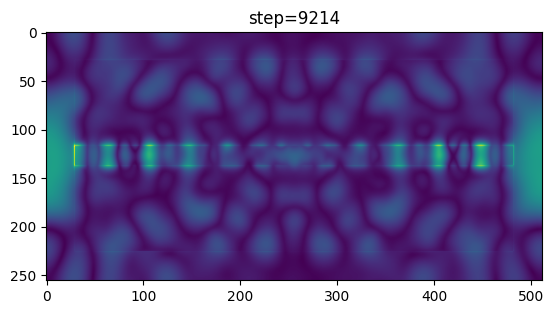

In [457]:
command_encoder = device.create_command_encoder()
command_encoder.copy_buffer_to_buffer(
    source=E_gpu,
    source_offset=0,
    destination=E_gpu_readback,
    destination_offset=0,
    size=E_cpu.data.nbytes
)
device.queue.submit([command_encoder.finish()])
device.queue.on_submitted_work_done_sync()

E_gpu_readback.map_sync(wgpu.MapMode.READ, 0, E_cpu.data.nbytes)
E_gpu_memview = E_gpu_readback.read_mapped(buffer_offset=0, size=E_cpu.data.nbytes, copy=True)
E_out = np.frombuffer(E_gpu_memview, dtype=np.float32)
E_out = np.reshape(E_out, E_cpu.shape)
E_gpu_readback.unmap()

plt.figure()
plt.title(f"step={curr_step}")
plt.imshow(np.sum(np.linalg.norm(E_out, ord=2, axis=3), axis=0))
#plt.imshow(np.sum(np.linalg.norm(E_out[7:11,:,:,:], ord=2, axis=3), axis=0))
#plt.imshow(np.linalg.norm(E_out[Nx//2,:,:,:], ord=2, axis=2))
#plt.imshow(np.linalg.norm(E_out[11,:,:,:], ord=2, axis=2))
#plt.colorbar()
plt.show()
plt.close()